# Семинар 1. Предобработка текстовых данных

<img src="data/imgs/photo-1472737817652-4120ab61af6c.jpeg">

Компьютеры не понимают человеческие языки, поэтому текстовые данные нужно каким-то образом преобразовывать. Это часто не простой и не тривиальный процесс. На этом занятии мы разберем основные способы очистки данных, нормализации и векторизации. Также мы посмотрим на готовые интрументы, предназначенные для работы с русским языком. В конце занятия мы попробуем порешать задачу автоматического определения тональности твитов.

## Очистка данных

Часто в данных, с которыми нам нужно работать помимо текста присутствует ещё какая-то лишняя информация: тэги, ссылки, код, разметка. От всего этого нужно избавляться.

In [1]:
# сразу импортируем все нужные библиотеки
# подробнее о каждой из них я расскажу по ходу
import string
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem
from nltk.corpus import stopwords
from string import punctuation
import re
mystem = Mystem()
morph = MorphAnalyzer()

# Классификация

Попробуем теперь применить эти знания на настоящей задаче. Возьмем данные Dialog Evaluation по анализу тональности твитов пользователей в адрес телекоммуникационных компаний. В изначальной формулировке нужно определять тональность относительно упомянутой компании, но мы упростим её до простого определения тональности твита.

Таким образом нам нужно по тексту твита приписать ему класс - негативный, нейтральный или положительный.

In [30]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
%matplotlib inline  
pd.set_option('max_colwidth', 1000)

In [31]:
# я заранее подготовил для вас данные
train_data = pd.read_csv('data/sentiment_twitter/train_sentiment_ttk.tsv', sep='\t')
test_data = pd.read_csv('data/sentiment_twitter/test_sentiment_ttk.tsv', sep='\t')

## Бейзлайн

В начале стоит попробовать самый простой возможный вариант. 
Count_vectorizer - без какой-либо нормализации подойдет.

In [39]:
# у count_vectorizer есть встроенный токенизатор, поэтому можно подавать текст напрямую
# обучим векторайзер на обучающей выборке и преобразуем тексты в векторы
count_vectorizer = CountVectorizer()
count_vectorizer.fit(train_data.text.values) 

X_train = count_vectorizer.transform(train_data.text.values)
X_test = count_vectorizer.transform(test_data.text.values)

In [42]:
# выделим классы в отдельные переменные
y_train = train_data.label.values
y_test = test_data.label.values

В качесте классификатора будем использовать Логистическую регрессию.

In [44]:
clf = LogisticRegression(penalty="l1", C=0.1)
clf.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [45]:
# предскажем значения тестовых твитов
y_pred = clf.predict(X_test)

In [46]:
# замерим качество классификации
print(classification_report(y_test, y_pred))
print('Макросредняя F1 мера - ',f1_score(y_test, y_pred, average='macro'))
print('Микросредняя F1 мера - ',f1_score(y_test, y_pred, average='micro'))

             precision    recall  f1-score   support

         -1       0.69      0.59      0.64       902
          0       0.61      0.80      0.69       972
          1       0.30      0.03      0.06       180

avg / total       0.62      0.64      0.61      2054

Макросредняя F1 мера -  0.46306421211286786
Микросредняя F1 мера -  0.6387536514118792


У некоторых классификаторов можно посмотреть значимость признаков. У логрега они хранится в ***clf.coef_*** . Это массив размером (количество классов, количество признаков). 

Признаки можно достать из векторайзера с помощью метода ***get_feature_names***.

Вместе их можно соотнести встроеной функцией *zip*. При использовании **L1** регуляризации значений признака можно интерпретировать как важность.

In [47]:
def print_important(vectorizer, clf, topn=10):
    features = vectorizer.get_feature_names()
    classes = clf.classes_
    importances = clf.coef_
    for i, cls in enumerate(classes):
        print('Значимые слова для класса - ', cls)
        important_words = sorted(list(zip(features, importances[i])), key=lambda x: abs(x[1]), reverse=True)[:topn]
        print([word for word,_ in important_words])
        print()


In [48]:
print_important(count_vectorizer, clf)

Значимые слова для класса -  -1
['сбой', 'tele2', 'старые', 'нет', 'проблемы', 'тарифов', 'сука', 'просит', 'отключили', 'крыму']

Значимые слова для класса -  0
['пожалуйста', 'гонконгские', 'связь', 'просит', 'цены', '20', 'иа', 'здравствуйте', 'скачать', 'для']

Значимые слова для класса -  1
['узбекистан', 'спасибо', 'клиенты', 'люблю', 'запустил', 'области', 'пожалуйста', '4g', 'увеличил', 'теперь']



### Попробуем теперь TfidfVectorizer.

In [53]:
tfidf = TfidfVectorizer()
tfidf.fit(train_data.text.values)
X_train = tfidf.transform(train_data.text.values)
X_test = tfidf.transform(test_data.text.values)

In [55]:
clf = LogisticRegression(penalty='l1')
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [56]:
y_pred = clf.predict(X_test)

In [57]:
# замерим качество классификации
print(classification_report(y_test, y_pred))
print('Макросредняя F1 мера - ',f1_score(y_test, y_pred, average='macro'))
print('Микросредняя F1 мера - ',f1_score(y_test, y_pred, average='micro'))

             precision    recall  f1-score   support

         -1       0.70      0.69      0.69       902
          0       0.66      0.76      0.71       972
          1       0.37      0.09      0.15       180

avg / total       0.65      0.67      0.65      2054

Макросредняя F1 мера -  0.5172604008633273
Микросредняя F1 мера -  0.6708860759493671


Также бывает полезно посмотреть на confision matrix.

Для красоты визуализируем с помощью библиотеки seaborn.

In [58]:
import seaborn as sns

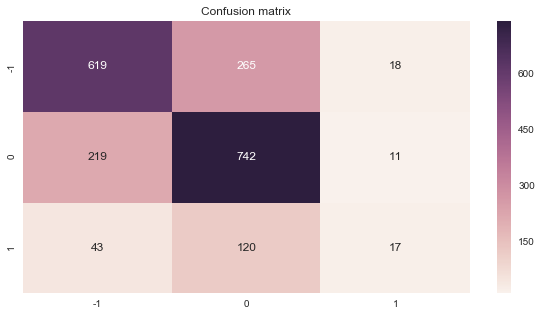

In [59]:
labels = clf.classes_
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True, 
            fmt="d", xticklabels=labels, yticklabels=labels, ax=ax)
plt.title("Confusion matrix")
plt.show()

In [60]:
# если не устанавливается, посмотрите просто так
confusion_matrix(y_test, y_pred)

array([[619, 265,  18],
       [219, 742,  11],
       [ 43, 120,  17]])

In [61]:
print_important(tfidf, clf, 20)

Значимые слова для класса -  -1
['сбой', 'tele2', 'старые', 'не', 'сука', 'говно', 'просит', 'проблемы', 'крыму', 'фас', 'нет', 'лежит', 'опять', 'спасибо', 'тарифов', 'украина', 'http', 'для', 'донецке', 'цены']

Значимые слова для класса -  0
['иа', 'просит', 'сбой', 'гонконгские', 'цены', 'границы', 'пожалуйста', 'сн', 'связь', 'ловит', 'здравствуйте', 'инструкция', 'http', 'люблю', 'для', 'ион', 'обратилась', 'долларов', 'даже', 'номер']

Значимые слова для класса -  1
['люблю', 'узбекистан', 'спасибо', 'расходы', 'пожалуйста', 'подарок', 'клиенты', 'бесплатный', 'увеличил', 'защиты', 'не', 'мировое', 'заработал', 'запустил', 'области', 'beeline_rus', 'хорошего', 'реклама', 'водителей', 'номер']



## Улучшение качества классификации

#### По самым характерным словам видно, что в корпусе есть мусор, стоп слова, разные формы одного слова. Чтобы улучшить результат попробуйте почистить данные и добавить нормализацию.

#### Перед тем, как перейти к нормализации, почистим данные от латиницы, цифр, @ и знаков препинания, а также уберём стоп-слова. 

In [96]:
def remove_latin_script(text):
    text = text.lower()
    return re.sub('[a-z0-9@]+', '', text)

In [97]:
punct_extended = string.punctuation + "@_«»—…“”"

In [84]:
# У меня не работает nltk.download(), совсем. Поэтому стоп-слова я нашла в интернете и вручную сделала массив.
stop_words = ['без', 'более', 'бы', 'был', 'была', 'были', 'было', 'быть', 'вам', 'вас', 'ведь', 'весь', 'вдоль', 'вместо', 'вне', 'вниз', 'внизу', 'внутри', 'во', 'вокруг', 'вот', 'все', 'всегда', 'всего', 'всех', 'вы', 'где', 'да', 'давай', 'давать', 'даже', 'для', 'до', 'его', 'ее', 'её', 'если', 'есть', 'ещё', 'же', 'за', 'здесь', 'из', 'из-за', 'или', 'им', 'иметь', 'их', 'как', 'как-то', 'кто', 'когда', 'кроме', 'кто', 'ли', 'либо', 'мне', 'может', 'мои', 'мой', 'мы', 'на', 'навсегда', 'над', 'надо', 'наш', 'не', 'него', 'неё', 'нет', 'ни', 'них', 'но', 'ну', 'об', 'однако', 'он', 'она', 'они', 'оно', 'от', 'отчего', 'очень', 'по', 'под', 'после', 'потому', 'потому что', 'почти', 'при', 'про', 'снова', 'со', 'так', 'также', 'такие', 'такой', 'там', 'те', 'тем', 'то', 'того', 'тоже', 'той', 'только', 'том', 'тут', 'ты', 'уже', 'хотя', 'чего', 'чего-то', 'чей', 'чем', 'что', 'чтобы', 'чьё', 'чья', 'эта', 'эти', 'это']

In [102]:
def normalize(text):
    """
    функция нормализации
    
    ::парметры::
    @text - ненормализованный текст (string)
    
    ::returns::
    нормализованный текст (string)
    """
    tokens = wordpunct_tokenize(text)
    unclear_lemmas = [morph.parse(token)[0].normal_form for token in tokens]
    lemmas = []
    for lemma in unclear_lemmas:
        if len(lemma) > 1 and lemma not in stops and lemma not in punct_extended:
            lemma = re.sub(r'://', '', lemma)
            lemma = re.sub(r'_', '', lemma)
            lemmas.append(remove_latin_script(lemma))

    return ' '.join(lemmas)
    

In [103]:
normalize('@text')

''

Чтобы применить нормализацию ко всему корпусу, воспользуйтесь функцией apply.

In [104]:
train_data['normalized'] = train_data['text'].apply(normalize)
test_data['normalized'] = test_data['text'].apply(normalize)

In [109]:
train_data.tail()

,label,text,normalized
8203,1,Понедвечер / / Сейчас буду делать уроки. Вот такая вот печаль.Кстати МТС мне понравился т. к. у него даже edge б.. http://t.co/FDj05cfvys,понедвечер сейчас делать урок печаль кстати мтс понравиться ..
8204,-1,"Ну если-же это МТС,то скорость интернета будет где-то 600-500 КБ/c,а для МТС это,действительно,4G:DD http://t.co/ycaeDyzRyV",мтс скорость интернет кб мтс действительно
8205,-1,RT @Olympialeigh: У МТС проблемы со связью из-за замены оборудования,мтс проблема связь замена оборудование
8206,-1,RT @ManisaMerkez45: У МТС проблемы со связью из-за замены оборудования,мтс проблема связь замена оборудование
8207,-1,RT @MertKaraoban: У МТС проблемы со связью из-за замены оборудования,мтс проблема связь замена оборудование


Обучите новую модель на нормализованных данных.

In [106]:
tfidf = TfidfVectorizer()
tfidf.fit(train_data['normalized'].values)

X_train = tfidf.transform(train_data['normalized'].values)
X_test = tfidf.transform(test_data['normalized'].values)

#### Логистическая регрессия

In [107]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [108]:
print(classification_report(y_test, y_pred))
print('Макросредняя F1 мера - ',f1_score(y_test, y_pred, average='macro'))
print('Микросредняя F1 мера - ',f1_score(y_test, y_pred, average='micro'))

             precision    recall  f1-score   support

         -1       0.76      0.57      0.65       902
          0       0.63      0.86      0.72       972
          1       0.53      0.13      0.21       180

avg / total       0.67      0.67      0.65      2054

Макросредняя F1 мера -  0.5260078481185041
Микросредняя F1 мера -  0.6665043816942551


Макросредняя F1 мера немного увеличилась, но Микросредняя уменьшилась. Попробуем понять, почему.

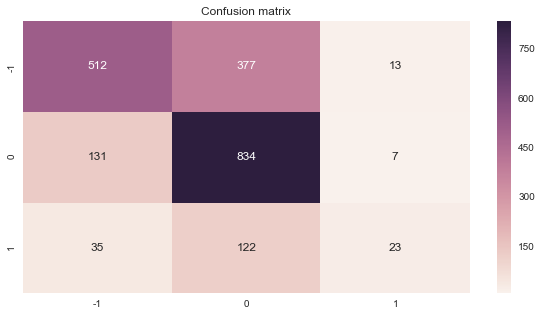

In [110]:
labels = clf.classes_
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True, 
            fmt="d", xticklabels=labels, yticklabels=labels, ax=ax)
plt.title("Confusion matrix")
plt.show()

Cудя по Confusion Matrix, классификатор ещё хуже отличает класс 0 от класса -1. Это может быть связано с тем, что некоторые стоп-слова были значимы для этих классов.

In [111]:
print_important(tfidf, clf, 20)

Значимые слова для класса -  -1
['крым', 'билайн', 'говно', 'почему', 'оштрафовать', 'запустить', 'ловить', 'опять', 'сук', 'восстановление', 'вчера', 'спасибо', 'связь', 'гавный', 'проблема', 'работать', 'лежать', 'смартфон', 'этот', 'сбой']

Значимые слова для класса -  0
['ловить', 'настройка', 'доллар', 'восстановление', 'инструкция', 'телефон', 'билайн', 'пожалуйста', 'скачать', 'номер', 'два', 'работать', 'крым', 'модем', 'вчера', 'кредит', 'говно', 'здравствовать', 'иа', 'оштрафовать']

Значимые слова для класса -  1
['узбекистан', 'запустить', 'спасибо', 'любить', 'хороший', 'заработать', 'защита', 'бесплатный', 'подарок', 'теперь', 'роуминг', 'область', 'реклама', 'радовать', 'телефон', 'ура', 'ваш', 'расход', 'какой', 'доступный']



Действительно, если сравнить списки слов с теми, что были раньше, мы увидим, что из класса -1 исчезли такие слова как "не" и "нет" (а ведь они могут быть важным показателем "негативности") Попробуем их вернуть.

In [117]:
stops.remove('не')
stops.remove('нет')
stops.remove('для')
stops.remove('без')

Повторим все прошлые шаги и посмотрим, изменилось ли что-нибудь:

In [120]:
train_data['normalized'] = train_data['text'].apply(normalize)
test_data['normalized'] = test_data['text'].apply(normalize)

In [121]:
tfidf = TfidfVectorizer()
tfidf.fit(train_data['normalized'].values)

X_train = tfidf.transform(train_data['normalized'].values)
X_test = tfidf.transform(test_data['normalized'].values)

In [122]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [123]:
print(classification_report(y_test, y_pred))
print('Макросредняя F1 мера - ',f1_score(y_test, y_pred, average='macro'))
print('Микросредняя F1 мера - ',f1_score(y_test, y_pred, average='micro'))

             precision    recall  f1-score   support

         -1       0.71      0.70      0.71       902
          0       0.67      0.78      0.72       972
          1       0.62      0.13      0.21       180

avg / total       0.68      0.69      0.67      2054

Макросредняя F1 мера -  0.5456461877922699
Микросредняя F1 мера -  0.6864654333008764


Да, изменилось! Как Макросредняя, так и Микросредняя мера показали улучшение качества классификатора! Посмотрим на confusion-matrix%

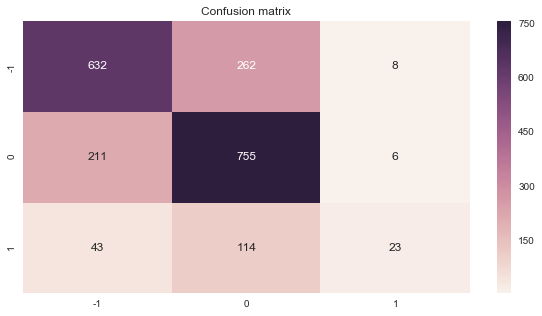

In [124]:
labels = clf.classes_
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True, 
            fmt="d", xticklabels=labels, yticklabels=labels, ax=ax)
plt.title("Confusion matrix")
plt.show()

Попробуем другие классификаторы.

#### SVC

In [134]:
from sklearn.svm import SVC

lin_svm = SVC(kernel='linear', C=10)

In [135]:
lin_svm.fit(X_train, y_train)
y_pred = lin_svm.predict(X_test)
print(classification_report(y_test, y_pred))
print('Макросредняя F1 мера - ',f1_score(y_test, y_pred, average='macro'))
print('Микросредняя F1 мера - ',f1_score(y_test, y_pred, average='micro'))

             precision    recall  f1-score   support

         -1       0.69      0.71      0.70       902
          0       0.68      0.68      0.68       972
          1       0.35      0.29      0.32       180

avg / total       0.65      0.66      0.66      2054

Макросредняя F1 мера -  0.5665500377913779
Микросредняя F1 мера -  0.6596884128529699


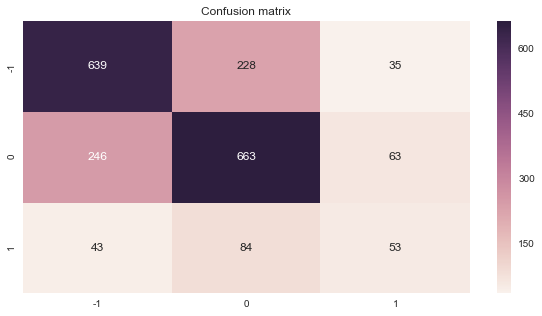

In [129]:
labels = lin_svm.classes_
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True, 
            fmt="d", xticklabels=labels, yticklabels=labels, ax=ax)
plt.title("Confusion matrix")
plt.show()

#### Random Forest

In [136]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

In [137]:
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))
print('Макросредняя F1 мера - ',f1_score(y_test, y_pred, average='macro'))
print('Микросредняя F1 мера - ',f1_score(y_test, y_pred, average='micro'))

             precision    recall  f1-score   support

         -1       0.65      0.67      0.66       902
          0       0.64      0.72      0.67       972
          1       0.51      0.12      0.19       180

avg / total       0.63      0.64      0.63      2054

Макросредняя F1 мера -  0.5079696741522977
Микросредняя F1 мера -  0.6416747809152873


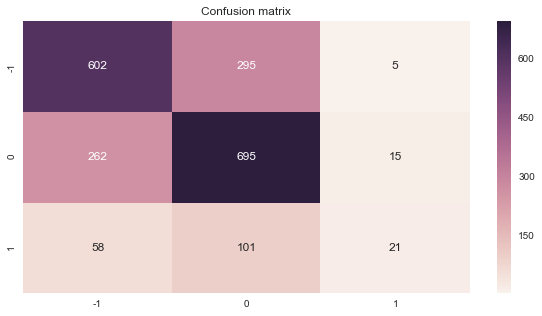

In [138]:
labels = rfc.classes_
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True, 
            fmt="d", xticklabels=labels, yticklabels=labels, ax=ax)
plt.title("Confusion matrix")
plt.show()